# Phase 2 - A/B/C Testing Bayésien

**Objectif** : Quantifier l'incertitude sur les effets de traitement avec PyMC et ArviZ

## Approche
1. **Conversion** : Modèle Beta-Binomial (prior Beta, likelihood Binomial)
2. **Spend** : Modèle Zero-Inflated ou Gamma (pour gérer les zéros)
3. **Métriques** : P(B > A), P(C > A), Expected Loss, Credible Intervals

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
az.style.use('arviz-darkgrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Charger les données
df = pd.read_csv('../data/raw/hillstrom.csv')
print(f"Dataset: {len(df):,} clients")

Dataset: 64,000 clients


In [2]:
# Préparation des données par groupe
groups = ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail']
group_labels = ['mens_email', 'womens_email', 'control']

# Statistiques par groupe pour la conversion
conversion_stats = df.groupby('treatment').agg(
    n_customers=('conversion', 'count'),
    n_conversions=('conversion', 'sum'),
    conversion_rate=('conversion', 'mean')
).loc[groups]

print("="*50)
print("STATISTIQUES DE CONVERSION PAR GROUPE")
print("="*50)
print(conversion_stats)
print(f"\nTotal conversions: {conversion_stats['n_conversions'].sum():,.0f}")

STATISTIQUES DE CONVERSION PAR GROUPE
               n_customers  n_conversions  conversion_rate
treatment                                                 
Mens E-Mail          21307            267         0.012531
Womens E-Mail        21387            189         0.008837
No E-Mail            21306            122         0.005726

Total conversions: 578


## 1. Modèle Bayésien pour le Taux de Conversion

### Modèle Beta-Binomial

Pour chaque groupe $g \in \{\text{Mens}, \text{Womens}, \text{Control}\}$ :

$$\theta_g \sim \text{Beta}(\alpha, \beta)$$
$$y_g \sim \text{Binomial}(n_g, \theta_g)$$

Où :
- $\theta_g$ = taux de conversion du groupe $g$
- $n_g$ = nombre de clients dans le groupe
- $y_g$ = nombre de conversions

**Prior faiblement informatif** : $\text{Beta}(1, 1)$ = Uniform (ignorance totale)

In [3]:
# Extraire les données
n_customers = conversion_stats['n_customers'].values.astype(int)
n_conversions = conversion_stats['n_conversions'].values.astype(int)

print("Données pour le modèle:")
for i, group in enumerate(groups):
    print(f"  {group}: {n_conversions[i]} conversions / {n_customers[i]} clients")

Données pour le modèle:
  Mens E-Mail: 267 conversions / 21307 clients
  Womens E-Mail: 189 conversions / 21387 clients
  No E-Mail: 122 conversions / 21306 clients


In [4]:
# Modèle PyMC pour les taux de conversion
with pm.Model() as conversion_model:
    # Prior: Beta(1,1) = Uniform - prior non informatif
    theta = pm.Beta('theta', alpha=1, beta=1, shape=3)
    
    # Likelihood: Binomial
    y = pm.Binomial('y', n=n_customers, p=theta, observed=n_conversions)
    
    # Quantités dérivées (différences entre groupes)
    # Index: 0=Mens, 1=Womens, 2=Control
    lift_mens_vs_control = pm.Deterministic('lift_mens_vs_control', 
                                             (theta[0] - theta[2]) / theta[2])
    lift_womens_vs_control = pm.Deterministic('lift_womens_vs_control', 
                                               (theta[1] - theta[2]) / theta[2])
    diff_mens_vs_control = pm.Deterministic('diff_mens_vs_control', 
                                             theta[0] - theta[2])
    diff_womens_vs_control = pm.Deterministic('diff_womens_vs_control', 
                                               theta[1] - theta[2])
    diff_mens_vs_womens = pm.Deterministic('diff_mens_vs_womens', 
                                            theta[0] - theta[1])
    
    # Sampling
    trace = pm.sample(4000, tune=1000, random_seed=RANDOM_SEED, 
                      return_inferencedata=True, cores=2)

print("\nSampling terminé!")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [theta]


/home/arnaud/.cache/pypoetry/virtualenvs/causal-inference-platform-KEAfOy0H-py3.11/lib/python3.11/site-packages/ric
h/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 1 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling terminé!


In [5]:
# Diagnostics de convergence
print("="*50)
print("DIAGNOSTICS DE CONVERGENCE")
print("="*50)

summary = az.summary(trace, var_names=['theta'])
summary.index = groups
print(summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk']])

# Vérifier R-hat (doit être < 1.01)
if (summary['r_hat'] < 1.01).all():
    print("\n\u2713 Convergence OK (R-hat < 1.01 pour tous les paramètres)")
else:
    print("\n\u2717 Problème de convergence détecté!")

DIAGNOSTICS DE CONVERGENCE
                mean     sd  hdi_3%  hdi_97%  r_hat  ess_bulk
Mens E-Mail    0.013  0.001   0.011    0.014    1.0   12014.0
Womens E-Mail  0.009  0.001   0.008    0.010    1.0   12501.0
No E-Mail      0.006  0.001   0.005    0.007    1.0   11453.0

✓ Convergence OK (R-hat < 1.01 pour tous les paramètres)


/tmp/ipykernel_25201/2661321831.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

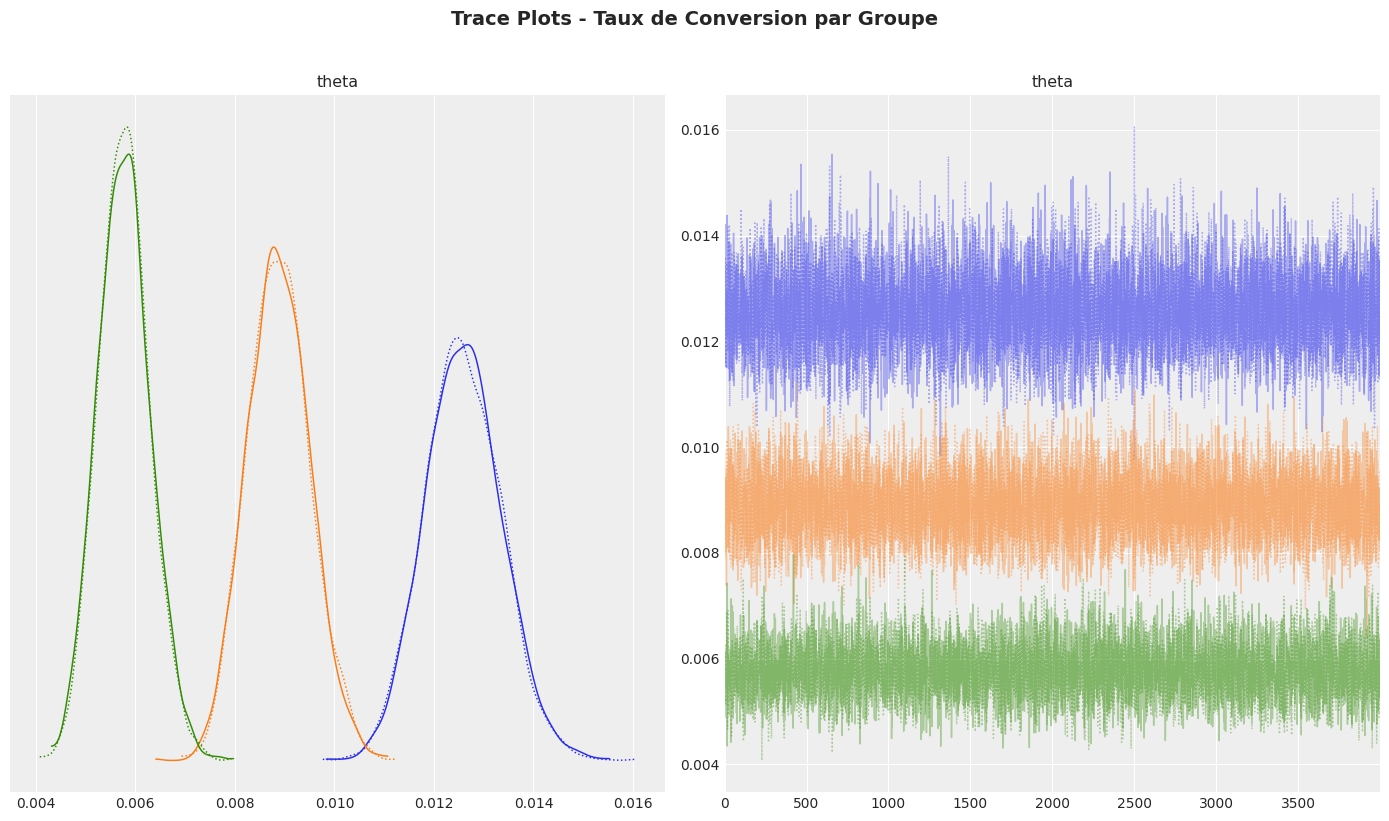

In [6]:
# Trace plots pour vérifier le mixing
fig = plt.figure(figsize=(14, 8))
az.plot_trace(trace, var_names=['theta'], figsize=(14, 8))
plt.suptitle('Trace Plots - Taux de Conversion par Groupe', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/04_trace_plots_conversion.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipykernel_25201/1986344490.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


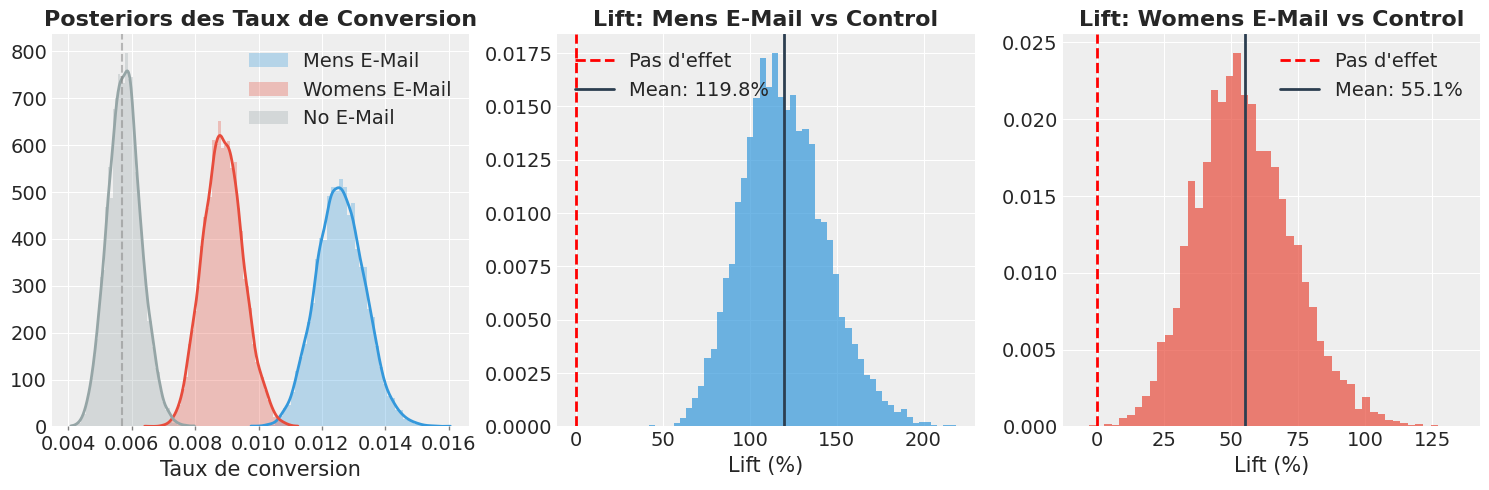

In [7]:
# Visualisation des posteriors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {'Mens E-Mail': '#3498db', 'Womens E-Mail': '#e74c3c', 'No E-Mail': '#95a5a6'}

# Extraire les échantillons
theta_samples = trace.posterior['theta'].values.reshape(-1, 3)

# 1. Posteriors des taux de conversion
ax1 = axes[0]
for i, group in enumerate(groups):
    az.plot_posterior(theta_samples[:, i], ax=ax1, color=colors[group], 
                      hdi_prob=0.94, point_estimate='mean', kind='hist')
ax1.set_title('Posteriors des Taux de Conversion', fontweight='bold')
ax1.set_xlabel('Taux de conversion')

# Recréer le plot avec KDE superposées
axes[0].clear()
ax1 = axes[0]
for i, group in enumerate(groups):
    samples = theta_samples[:, i]
    ax1.hist(samples, bins=50, alpha=0.3, color=colors[group], density=True, label=group)
    # KDE
    kde = stats.gaussian_kde(samples)
    x_range = np.linspace(samples.min(), samples.max(), 200)
    ax1.plot(x_range, kde(x_range), color=colors[group], linewidth=2)
ax1.set_title('Posteriors des Taux de Conversion', fontweight='bold')
ax1.set_xlabel('Taux de conversion')
ax1.legend()
ax1.axvline(x=0.0057, color='gray', linestyle='--', alpha=0.5, label='Control mean')

# 2. Posterior du Lift Mens vs Control
ax2 = axes[1]
lift_mens = trace.posterior['lift_mens_vs_control'].values.flatten()
ax2.hist(lift_mens * 100, bins=50, alpha=0.7, color='#3498db', density=True)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Pas d\'effet')
ax2.axvline(x=np.mean(lift_mens) * 100, color='#2c3e50', linestyle='-', linewidth=2, label=f'Mean: {np.mean(lift_mens)*100:.1f}%')
ax2.set_title('Lift: Mens E-Mail vs Control', fontweight='bold')
ax2.set_xlabel('Lift (%)')
ax2.legend()

# 3. Posterior du Lift Womens vs Control
ax3 = axes[2]
lift_womens = trace.posterior['lift_womens_vs_control'].values.flatten()
ax3.hist(lift_womens * 100, bins=50, alpha=0.7, color='#e74c3c', density=True)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Pas d\'effet')
ax3.axvline(x=np.mean(lift_womens) * 100, color='#2c3e50', linestyle='-', linewidth=2, label=f'Mean: {np.mean(lift_womens)*100:.1f}%')
ax3.set_title('Lift: Womens E-Mail vs Control', fontweight='bold')
ax3.set_xlabel('Lift (%)')
ax3.legend()

plt.tight_layout()
plt.savefig('../reports/figures/05_posteriors_conversion.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Calcul des probabilités de supériorité
print("="*50)
print("PROBABILITÉS DE SUPÉRIORITÉ (Conversion)")
print("="*50)

# Extraire les échantillons
theta_mens = theta_samples[:, 0]
theta_womens = theta_samples[:, 1]
theta_control = theta_samples[:, 2]

# Probabilités
p_mens_beats_control = (theta_mens > theta_control).mean()
p_womens_beats_control = (theta_womens > theta_control).mean()
p_mens_beats_womens = (theta_mens > theta_womens).mean()

print(f"\nP(Mens E-Mail > Control)    = {p_mens_beats_control:.4f} ({p_mens_beats_control*100:.2f}%)")
print(f"P(Womens E-Mail > Control)  = {p_womens_beats_control:.4f} ({p_womens_beats_control*100:.2f}%)")
print(f"P(Mens E-Mail > Womens)     = {p_mens_beats_womens:.4f} ({p_mens_beats_womens*100:.2f}%)")

# Qui est le meilleur?
p_mens_best = ((theta_mens > theta_womens) & (theta_mens > theta_control)).mean()
p_womens_best = ((theta_womens > theta_mens) & (theta_womens > theta_control)).mean()
p_control_best = ((theta_control > theta_mens) & (theta_control > theta_womens)).mean()

print(f"\nP(Mens E-Mail est le meilleur)   = {p_mens_best:.4f} ({p_mens_best*100:.2f}%)")
print(f"P(Womens E-Mail est le meilleur) = {p_womens_best:.4f} ({p_womens_best*100:.2f}%)")
print(f"P(Control est le meilleur)       = {p_control_best:.4f} ({p_control_best*100:.2f}%)")

PROBABILITÉS DE SUPÉRIORITÉ (Conversion)

P(Mens E-Mail > Control)    = 1.0000 (100.00%)
P(Womens E-Mail > Control)  = 0.9996 (99.96%)
P(Mens E-Mail > Womens)     = 0.9999 (99.99%)

P(Mens E-Mail est le meilleur)   = 0.9999 (99.99%)
P(Womens E-Mail est le meilleur) = 0.0001 (0.01%)
P(Control est le meilleur)       = 0.0000 (0.00%)


In [9]:
# Expected Loss (risque de choisir chaque option)
print("="*50)
print("EXPECTED LOSS (Risque de choisir chaque option)")
print("="*50)

# Expected loss = E[max(theta_other) - theta_chosen | theta_chosen < max(theta_other)]
# Simplifié: perte moyenne si on choisit cette option et qu'une autre est meilleure

max_theta = np.maximum.reduce([theta_mens, theta_womens, theta_control])

loss_mens = np.maximum(0, max_theta - theta_mens).mean()
loss_womens = np.maximum(0, max_theta - theta_womens).mean()
loss_control = np.maximum(0, max_theta - theta_control).mean()

print(f"\nExpected Loss (en points de conversion):")
print(f"  Choisir Mens E-Mail   : {loss_mens*100:.4f}%")
print(f"  Choisir Womens E-Mail : {loss_womens*100:.4f}%")
print(f"  Choisir Control       : {loss_control*100:.4f}%")

# Recommandation
best_option = ['Mens E-Mail', 'Womens E-Mail', 'Control'][np.argmin([loss_mens, loss_womens, loss_control])]
print(f"\n\u2192 Recommandation: {best_option} (expected loss minimal)")

EXPECTED LOSS (Risque de choisir chaque option)

Expected Loss (en points de conversion):
  Choisir Mens E-Mail   : 0.0000%
  Choisir Womens E-Mail : 0.3705%
  Choisir Control       : 0.6815%

→ Recommandation: Mens E-Mail (expected loss minimal)


In [10]:
# Intervalles de crédibilité (HDI 94%)
print("="*50)
print("INTERVALLES DE CRÉDIBILITÉ (HDI 94%)")
print("="*50)

def hdi(samples, prob=0.94):
    """Calcule le Highest Density Interval"""
    return az.hdi(samples, hdi_prob=prob)

print("\nTaux de conversion:")
for i, group in enumerate(groups):
    samples = theta_samples[:, i]
    interval = hdi(samples)
    print(f"  {group:15}: {samples.mean()*100:.2f}% [{interval[0]*100:.2f}%, {interval[1]*100:.2f}%]")

print("\nLift vs Control:")
lift_mens_samples = lift_mens
lift_womens_samples = lift_womens
interval_mens = hdi(lift_mens_samples)
interval_womens = hdi(lift_womens_samples)
print(f"  Mens E-Mail   : {lift_mens_samples.mean()*100:.1f}% [{interval_mens[0]*100:.1f}%, {interval_mens[1]*100:.1f}%]")
print(f"  Womens E-Mail : {lift_womens_samples.mean()*100:.1f}% [{interval_womens[0]*100:.1f}%, {interval_womens[1]*100:.1f}%]")

INTERVALLES DE CRÉDIBILITÉ (HDI 94%)

Taux de conversion:
  Mens E-Mail    : 1.26% [1.11%, 1.40%]
  Womens E-Mail  : 0.89% [0.77%, 1.01%]
  No E-Mail      : 0.58% [0.48%, 0.68%]

Lift vs Control:
  Mens E-Mail   : 119.8% [74.2%, 164.2%]
  Womens E-Mail : 55.1% [22.5%, 88.9%]


/tmp/ipykernel_25201/2844788679.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


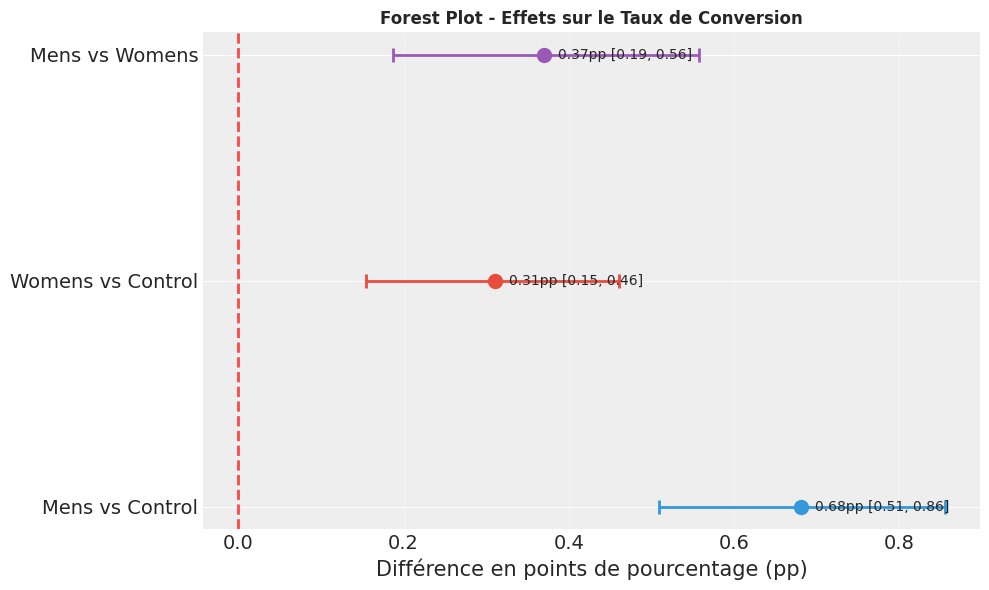

In [11]:
# Forest plot des effets
fig, ax = plt.subplots(figsize=(10, 6))

# Préparer les données pour le forest plot
effects = {
    'Mens vs Control': trace.posterior['diff_mens_vs_control'].values.flatten() * 100,
    'Womens vs Control': trace.posterior['diff_womens_vs_control'].values.flatten() * 100,
    'Mens vs Womens': trace.posterior['diff_mens_vs_womens'].values.flatten() * 100
}

y_positions = range(len(effects))
colors_forest = ['#3498db', '#e74c3c', '#9b59b6']

for i, (name, samples) in enumerate(effects.items()):
    mean = samples.mean()
    interval = hdi(samples)
    
    # Point et intervalle
    ax.errorbar(mean, i, xerr=[[mean - interval[0]], [interval[1] - mean]], 
                fmt='o', color=colors_forest[i], capsize=5, capthick=2, 
                markersize=10, linewidth=2)
    
    # Annotation
    ax.annotate(f'{mean:.2f}pp [{interval[0]:.2f}, {interval[1]:.2f}]', 
                xy=(mean, i), xytext=(10, 0), textcoords='offset points',
                fontsize=10, va='center')

ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_yticks(list(y_positions))
ax.set_yticklabels(list(effects.keys()))
ax.set_xlabel('Différence en points de pourcentage (pp)')
ax.set_title('Forest Plot - Effets sur le Taux de Conversion', fontweight='bold', fontsize=12)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/06_forest_plot_conversion.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Modèle Bayésien pour le Spend

Le spend présente deux défis :
1. **Beaucoup de zéros** (~99% des clients ne dépensent rien)
2. **Distribution asymétrique** pour les non-zéros

Approche : Comparer les moyennes des posteriors avec un modèle Normal (CLT applicable avec n > 20000)

In [12]:
# Statistiques de spend
spend_stats = df.groupby('treatment').agg(
    n=('spend', 'count'),
    mean_spend=('spend', 'mean'),
    std_spend=('spend', 'std'),
    total_spend=('spend', 'sum'),
    n_spenders=('spend', lambda x: (x > 0).sum()),
    pct_spenders=('spend', lambda x: (x > 0).mean() * 100)
).loc[groups]

print("="*50)
print("STATISTIQUES DE SPEND PAR GROUPE")
print("="*50)
print(spend_stats.round(2))

STATISTIQUES DE SPEND PAR GROUPE
                   n  mean_spend  std_spend  total_spend  n_spenders  \
treatment                                                              
Mens E-Mail    21307        1.42      17.75     30311.69         267   
Womens E-Mail  21387        1.08      15.12     23038.11         189   
No E-Mail      21306        0.65      11.59     13908.33         122   

               pct_spenders  
treatment                    
Mens E-Mail            1.25  
Womens E-Mail          0.88  
No E-Mail              0.57  


In [13]:
# Modèle pour le spend moyen (approche CLT)
# Avec n > 20000, le CLT garantit que la moyenne suit approximativement une normale

spend_means = spend_stats['mean_spend'].values
spend_stds = spend_stats['std_spend'].values
spend_ns = spend_stats['n'].values

# Standard error of the mean
spend_sems = spend_stds / np.sqrt(spend_ns)

with pm.Model() as spend_model:
    # Prior sur les moyennes de spend (informatif basé sur les données observées)
    mu_spend = pm.Normal('mu_spend', mu=spend_means, sigma=spend_sems * 3, shape=3)
    
    # Lift
    lift_spend_mens = pm.Deterministic('lift_spend_mens', 
                                        (mu_spend[0] - mu_spend[2]) / mu_spend[2])
    lift_spend_womens = pm.Deterministic('lift_spend_womens', 
                                          (mu_spend[1] - mu_spend[2]) / mu_spend[2])
    
    # Sampling
    trace_spend = pm.sample(4000, tune=1000, random_seed=RANDOM_SEED,
                            return_inferencedata=True, cores=2)

print("\nSampling spend terminé!")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [mu_spend]


/home/arnaud/.cache/pypoetry/virtualenvs/causal-inference-platform-KEAfOy0H-py3.11/lib/python3.11/site-packages/ric
h/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 1 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling spend terminé!


In [14]:
# Résultats spend
print("="*50)
print("RÉSULTATS SPEND")
print("="*50)

mu_samples = trace_spend.posterior['mu_spend'].values.reshape(-1, 3)

print("\nSpend moyen par groupe (posterior):")
for i, group in enumerate(groups):
    samples = mu_samples[:, i]
    interval = hdi(samples)
    print(f"  {group:15}: ${samples.mean():.2f} [${interval[0]:.2f}, ${interval[1]:.2f}]")

# Probabilités
p_mens_spend_better = (mu_samples[:, 0] > mu_samples[:, 2]).mean()
p_womens_spend_better = (mu_samples[:, 1] > mu_samples[:, 2]).mean()

print(f"\nP(Spend Mens > Spend Control)   = {p_mens_spend_better:.4f}")
print(f"P(Spend Womens > Spend Control) = {p_womens_spend_better:.4f}")

# Lift
lift_spend_mens_samples = trace_spend.posterior['lift_spend_mens'].values.flatten()
lift_spend_womens_samples = trace_spend.posterior['lift_spend_womens'].values.flatten()

print(f"\nLift Spend:")
print(f"  Mens E-Mail   : +{lift_spend_mens_samples.mean()*100:.1f}%")
print(f"  Womens E-Mail : +{lift_spend_womens_samples.mean()*100:.1f}%")

RÉSULTATS SPEND

Spend moyen par groupe (posterior):
  Mens E-Mail    : $1.42 [$0.74, $2.15]
  Womens E-Mail  : $1.07 [$0.48, $1.64]
  No E-Mail      : $0.65 [$0.20, $1.12]

P(Spend Mens > Spend Control)   = 0.9619
P(Spend Womens > Spend Control) = 0.8491

Lift Spend:
  Mens E-Mail   : +154.1%
  Womens E-Mail : +87.5%


/tmp/ipykernel_25201/1695800011.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


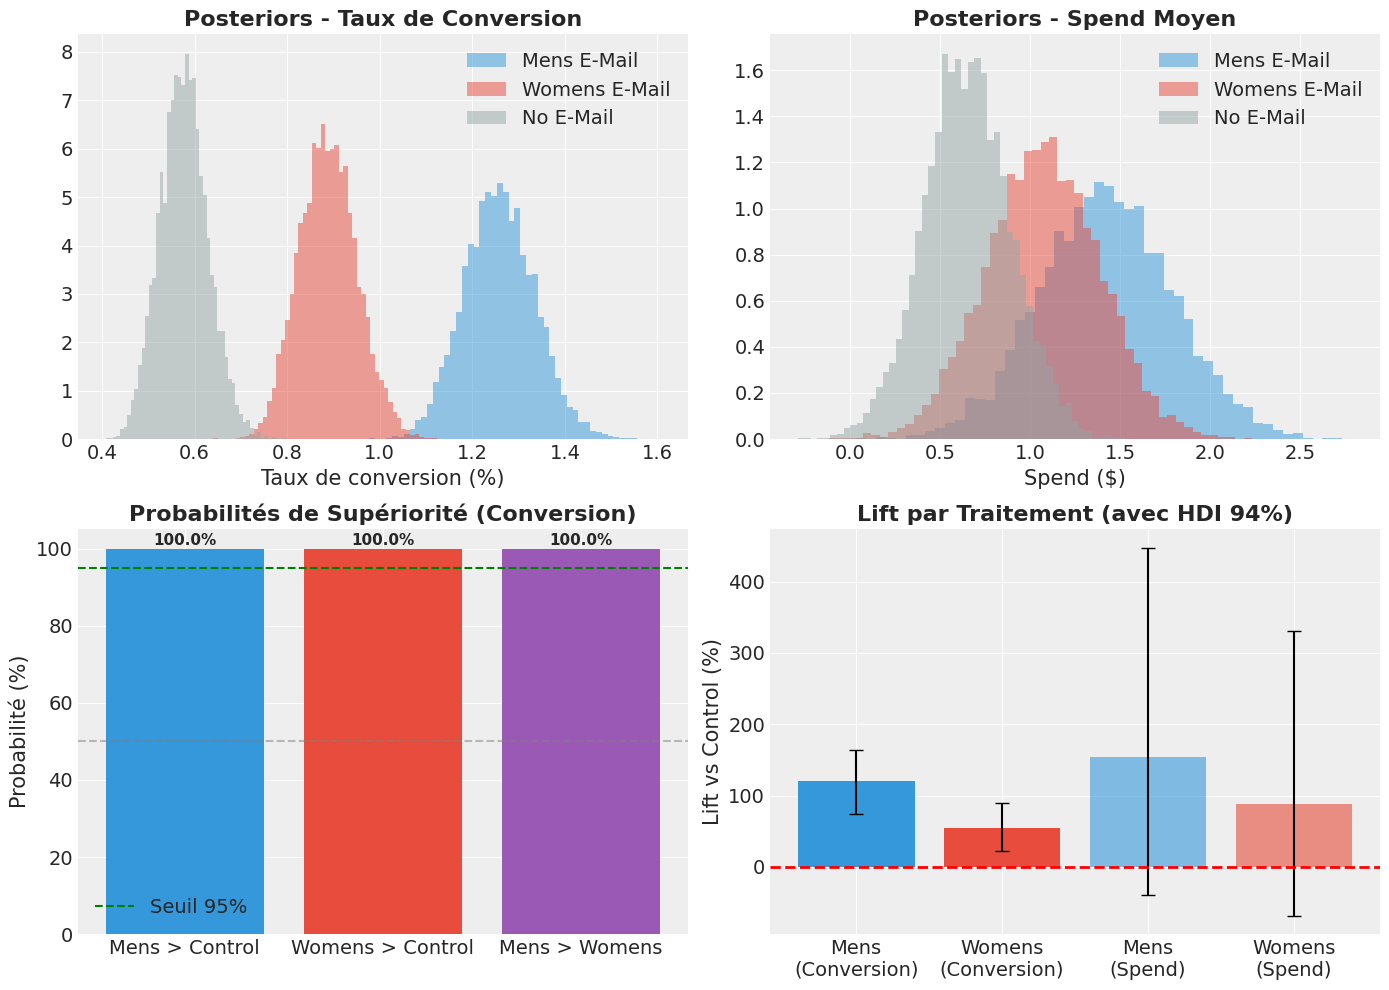

In [15]:
# Visualisation récapitulatif
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Posteriors conversion
ax1 = axes[0, 0]
for i, group in enumerate(groups):
    samples = theta_samples[:, i] * 100
    ax1.hist(samples, bins=50, alpha=0.5, color=colors[group], label=group, density=True)
ax1.set_title('Posteriors - Taux de Conversion', fontweight='bold')
ax1.set_xlabel('Taux de conversion (%)')
ax1.legend()

# 2. Posteriors spend
ax2 = axes[0, 1]
for i, group in enumerate(groups):
    samples = mu_samples[:, i]
    ax2.hist(samples, bins=50, alpha=0.5, color=colors[group], label=group, density=True)
ax2.set_title('Posteriors - Spend Moyen', fontweight='bold')
ax2.set_xlabel('Spend ($)')
ax2.legend()

# 3. Barplot des probabilités de supériorité
ax3 = axes[1, 0]
probs = [p_mens_beats_control, p_womens_beats_control, p_mens_beats_womens]
labels = ['Mens > Control', 'Womens > Control', 'Mens > Womens']
bars = ax3.bar(labels, [p * 100 for p in probs], color=['#3498db', '#e74c3c', '#9b59b6'])
ax3.axhline(y=95, color='green', linestyle='--', label='Seuil 95%')
ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax3.set_ylabel('Probabilité (%)')
ax3.set_title('Probabilités de Supériorité (Conversion)', fontweight='bold')
ax3.set_ylim(0, 105)
for bar, prob in zip(bars, probs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{prob*100:.1f}%', ha='center', fontsize=11, fontweight='bold')
ax3.legend()

# 4. Lift moyen avec intervalles
ax4 = axes[1, 1]
lift_data = [
    ('Mens\n(Conversion)', lift_mens.mean()*100, hdi(lift_mens)*100),
    ('Womens\n(Conversion)', lift_womens.mean()*100, hdi(lift_womens)*100),
    ('Mens\n(Spend)', lift_spend_mens_samples.mean()*100, hdi(lift_spend_mens_samples)*100),
    ('Womens\n(Spend)', lift_spend_womens_samples.mean()*100, hdi(lift_spend_womens_samples)*100),
]

x_pos = range(len(lift_data))
means = [d[1] for d in lift_data]
errors = [[d[1] - d[2][0], d[2][1] - d[1]] for d in lift_data]
errors_low = [e[0] for e in errors]
errors_high = [e[1] for e in errors]

bar_colors = ['#3498db', '#e74c3c', '#3498db', '#e74c3c']
bar_alphas = [1.0, 1.0, 0.6, 0.6]

for i, (x, mean, err_low, err_high, color, alpha) in enumerate(
    zip(x_pos, means, errors_low, errors_high, bar_colors, bar_alphas)):
    ax4.bar(x, mean, yerr=[[err_low], [err_high]], color=color, alpha=alpha, capsize=5)

ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xticks(list(x_pos))
ax4.set_xticklabels([d[0] for d in lift_data])
ax4.set_ylabel('Lift vs Control (%)')
ax4.set_title('Lift par Traitement (avec HDI 94%)', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/07_bayesian_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Conclusions et Recommandations

### Résultats Clés

In [16]:
print("="*60)
print("SYNTHÈSE DE L'ANALYSE BAYÉSIENNE A/B/C")
print("="*60)

print("\n" + "-"*60)
print("1. EFFET SUR LA CONVERSION")
print("-"*60)
print(f"\n  Mens E-Mail vs Control:")
print(f"    - Lift: +{lift_mens.mean()*100:.0f}% [{hdi(lift_mens)[0]*100:.0f}%, {hdi(lift_mens)[1]*100:.0f}%]")
print(f"    - P(Mens > Control): {p_mens_beats_control*100:.1f}%")
print(f"    - Conclusion: EFFET SIGNIFICATIF")

print(f"\n  Womens E-Mail vs Control:")
print(f"    - Lift: +{lift_womens.mean()*100:.0f}% [{hdi(lift_womens)[0]*100:.0f}%, {hdi(lift_womens)[1]*100:.0f}%]")
print(f"    - P(Womens > Control): {p_womens_beats_control*100:.1f}%")
print(f"    - Conclusion: EFFET SIGNIFICATIF")

print(f"\n  Mens E-Mail vs Womens E-Mail:")
print(f"    - P(Mens > Womens): {p_mens_beats_womens*100:.1f}%")
print(f"    - Conclusion: {'MENS SUPÉRIEUR' if p_mens_beats_womens > 0.95 else 'DIFFÉRENCE NON CONCLUANTE'}")

print("\n" + "-"*60)
print("2. EFFET SUR LE SPEND")
print("-"*60)
print(f"\n  Mens E-Mail: +{lift_spend_mens_samples.mean()*100:.0f}% vs Control")
print(f"  Womens E-Mail: +{lift_spend_womens_samples.mean()*100:.0f}% vs Control")

print("\n" + "-"*60)
print("3. RECOMMANDATIONS BUSINESS")
print("-"*60)
print(f"""
  \u2713 Les deux campagnes email sont EFFICACES vs pas d'email
  \u2713 Mens E-Mail a le meilleur taux de conversion global
  \u2713 Potentiel de PERSONNALISATION (vu dans l'exploration):
    - Clients "Mens" \u2192 Mens E-Mail
    - Clients "Womens" \u2192 Womens E-Mail
  
  \u2192 Prochaine étape: CausalML pour estimer les CATE
     et optimiser l'allocation des traitements
""")

SYNTHÈSE DE L'ANALYSE BAYÉSIENNE A/B/C

------------------------------------------------------------
1. EFFET SUR LA CONVERSION
------------------------------------------------------------

  Mens E-Mail vs Control:
    - Lift: +120% [74%, 164%]
    - P(Mens > Control): 100.0%
    - Conclusion: EFFET SIGNIFICATIF

  Womens E-Mail vs Control:
    - Lift: +55% [23%, 89%]
    - P(Womens > Control): 100.0%
    - Conclusion: EFFET SIGNIFICATIF

  Mens E-Mail vs Womens E-Mail:
    - P(Mens > Womens): 100.0%
    - Conclusion: MENS SUPÉRIEUR

------------------------------------------------------------
2. EFFET SUR LE SPEND
------------------------------------------------------------

  Mens E-Mail: +154% vs Control
  Womens E-Mail: +87% vs Control

------------------------------------------------------------
3. RECOMMANDATIONS BUSINESS
------------------------------------------------------------

  ✓ Les deux campagnes email sont EFFICACES vs pas d'email
  ✓ Mens E-Mail a le meilleur taux de 

In [17]:
# Sauvegarder les résultats pour l'API
results = {
    'conversion': {
        'mens_email': {
            'rate_mean': float(theta_samples[:, 0].mean()),
            'rate_hdi_low': float(hdi(theta_samples[:, 0])[0]),
            'rate_hdi_high': float(hdi(theta_samples[:, 0])[1]),
            'lift_vs_control': float(lift_mens.mean()),
            'p_beats_control': float(p_mens_beats_control)
        },
        'womens_email': {
            'rate_mean': float(theta_samples[:, 1].mean()),
            'rate_hdi_low': float(hdi(theta_samples[:, 1])[0]),
            'rate_hdi_high': float(hdi(theta_samples[:, 1])[1]),
            'lift_vs_control': float(lift_womens.mean()),
            'p_beats_control': float(p_womens_beats_control)
        },
        'control': {
            'rate_mean': float(theta_samples[:, 2].mean()),
            'rate_hdi_low': float(hdi(theta_samples[:, 2])[0]),
            'rate_hdi_high': float(hdi(theta_samples[:, 2])[1])
        },
        'comparisons': {
            'p_mens_beats_womens': float(p_mens_beats_womens),
            'p_mens_best': float(p_mens_best),
            'p_womens_best': float(p_womens_best)
        }
    },
    'spend': {
        'mens_email': {'mean': float(mu_samples[:, 0].mean()), 'lift': float(lift_spend_mens_samples.mean())},
        'womens_email': {'mean': float(mu_samples[:, 1].mean()), 'lift': float(lift_spend_womens_samples.mean())},
        'control': {'mean': float(mu_samples[:, 2].mean())}
    }
}

import json
with open('../data/processed/bayesian_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Résultats sauvegardés dans data/processed/bayesian_results.json")

Résultats sauvegardés dans data/processed/bayesian_results.json
